In [382]:
# Final version of Ex_1
# Do we need to csv for the df_EUR_M dataframes?
# Datasets not restricted to years 2008-2022
# Correlation doesn't work

# Create (monthly) dataset

In [383]:
'''pip install pandas
pip install matplotlib
pip install numpy'''

'pip install pandas\npip install matplotlib\npip install numpy'

In [384]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [385]:
#Monthly_reurn include 278 months and 2051 firms (rows)
M_RI_path = r'C:\Users\giuli\Documents\SEF_Homework1\SEF\ESG_Scores\DS_RI_T_USD_M.xlsx'  # Replace with your Excel file name
df_M_RI = pd.read_excel(M_RI_path)

#Monthly_capitalization include 278 months and 2051 firms 
M_cap_path = r'C:\Users\giuli\Documents\SEF_Homework1\SEF\ESG_Scores\DS_MV_USD_M.xlsx'  # Replace with your Excel file name
df_M_cap = pd.read_excel(M_cap_path)

#Country to region data
region_path = r'C:\Users\giuli\Documents\SEF_Homework1\SEF\CountriesToRegions.xlsx'  # Replace with your Excel file name
df_region = pd.read_excel(region_path)

In [386]:
#Let's keep only the EUR contries

df_region.drop(index=[0,1,2,3], inplace= True )

df_EUR = df_region[df_region['Unnamed: 2'] == 'EUR']

In [387]:
#Rename the column so we can merge later
df_EUR = df_EUR.rename(columns={'% AMER: Cnada + USA' : 'ISIN_First2'})

In [388]:
#Merging the datasets 
#First step: create a column with only the 2 first characters of the column ISIN

#For the return index dataset
df_M_RI['ISIN_First2'] = df_M_RI ['ISIN'].str[:2]
#df_M_RI

In [389]:
#For the capitlization dataset
df_M_cap['ISIN_First2'] = df_M_cap ['ISIN'].str[:2]
#df_M_cap

In [390]:
#Second step: merge the IR and capitalization datasets with the region dataset, keeping only EUR firms
df_EUR_M_cap = pd.merge(df_EUR,  df_M_cap, on='ISIN_First2', how='inner')
df_EUR_M_RI = pd.merge(df_EUR,  df_M_RI, on='ISIN_First2', how='inner')


In [391]:
df_EUR_M_cap.to_csv('/Users/giuli\Documents\SEF_Homework1\SEF/df_EUR_monthly_capitalization.csv', index=False)
df_EUR_M_RI.to_csv('/Users/giuli\Documents\SEF_Homework1\SEF/df_EUR_monthly_RI.csv', index=False)
#We have now 508 firms with data for 281 months (minus the first columns)

# Import datasets

### Import monthly datasets

In [392]:
#Import monthly capitalization dataset for EUR firms
#url = "https://raw.githubusercontent.com/GiammarcoBozzelli/SEF/main/df_EUR_monthly_capitalization.csv"
#df_EUR_M_cap = pd.read_csv(url)

In [393]:
#Import monthly return index (RI) dataset for EUR firms
#url0 = "https://raw.githubusercontent.com/GiammarcoBozzelli/SEF/main/df_EUR_monthly_return.csv"
#df_EUR_M_RI = pd.read_csv(url0)
#df_RI_monthly

### Import yearly datasets

In [394]:
#Import yearly capitalization dataset for EUR firms
#url1 = "https://raw.githubusercontent.com/GiammarcoBozzelli/SEF/main/df_EUR_yearly_capitalization.csv"
#df_EUR_Y_cap = pd.read_csv(url1)

In [395]:
#Import yearly return index (RI) dataset for EUR firms
#url2 = "https://raw.githubusercontent.com/GiammarcoBozzelli/SEF/main/df_EUR_yearly_return.csv"
#df_EUR_Y_RI = pd.read_csv(url2)

# Question 1

Compute the annualized average RI and annualized volatility for all individual assets over the period 2008–2022. Plot and comment the histogram of these distributions. Compute and comment on the correlation between individual average RIs and volatilities in the cross section. (10 points)

### Annualized average return

In [396]:
df_EUR_M_cap.drop(df_EUR_M_cap.columns[:4], axis=1, inplace=True)
df_EUR_M_cap.set_index('NAME', inplace = True)
#df_EUR_M_cap_08 = df_EUR_M_cap.loc[:, (df_EUR_M_cap.columns >= "2008-01-01")]
#df_EUR_M_cap_T = df_EUR_M_cap_08.T
df_EUR_M_cap_T = df_EUR_M_cap.T
#df_EUR_M_cap_T

In [397]:
df_M_returns = df_EUR_M_cap_T.pct_change()

In [398]:
df_M_returns_annualized = df_M_returns.mean() * 12

<Axes: xlabel='NAME'>

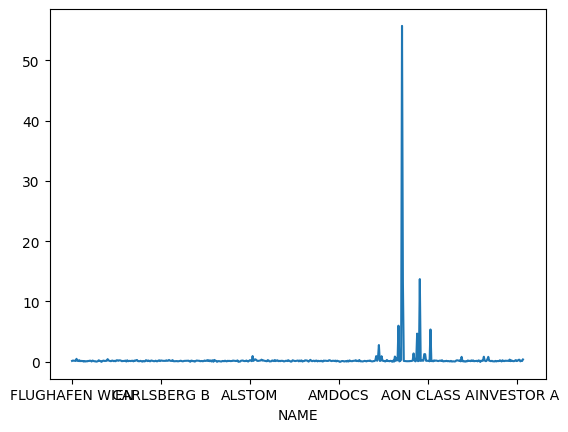

In [399]:
df_M_returns_annualized.plot()

<Axes: ylabel='Count'>

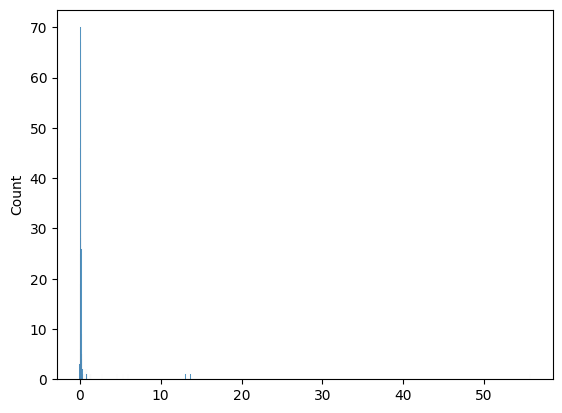

In [400]:
sns.histplot(df_M_returns_annualized)

### Annualized volatility

In [401]:
deviations = df_M_returns - df_M_returns.mean()
squared_deviations = deviations**2
mean_squared_deviations = squared_deviations.mean()

df_M_volatility = np.sqrt(mean_squared_deviations)

In [402]:
df_M_volatility_annualized = df_M_volatility*(12**0.5)

<Axes: xlabel='NAME'>

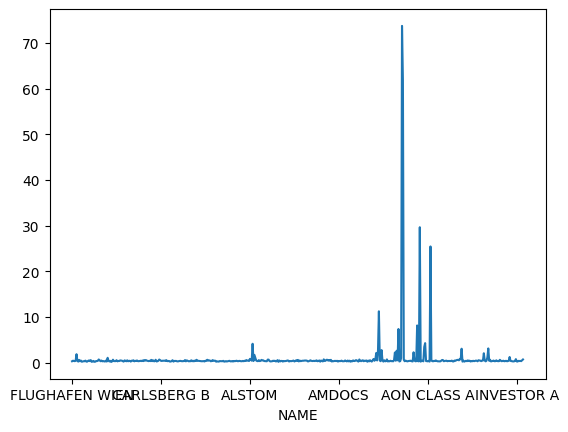

In [403]:
df_M_volatility_annualized.plot()

### Correlation

In [404]:
df = pd.DataFrame()
df["returns"] = df_M_returns_annualized

In [405]:

df["volatility"]=df_M_volatility_annualized

In [406]:
df.corr()
     

df["corr"] = 0
for i in df.index:
    df.loc[i, "corr"] = df.loc[i, "returns"].corr(df.loc[i, "volatility"], method="pearson")
     

df.loc[i]["corr"]

AttributeError: 'numpy.float64' object has no attribute 'corr'